# Implementing alternate algorithm

Implementing algorithm that splits up procedure into two steps: 
1. carving out sleeves (exploting projection dynamics)
2. running dijkstra on new graph

In [1]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import networkx as nx
from util.pqdict import pqdict
from util.trajectories import *
from util.alg_perf import *

In [43]:
def proj_dist(proj1, proj2):
    return np.linalg.norm(proj1 - proj2)

def get_next_proj(SC, u, v, curr_proj):
    edge = Trajectory(SC, [u,v], 0)
    proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
    next_proj = curr_proj + proj
    return next_proj

def make_sleeve_graph(SC, start, end, ref_path):
    G_sleeve = nx.Graph()
    pq = pqdict(reverse=True)
    node_indices = np.where(SC.node_vec != 0)[0]
    node_dict = {node:0 for node in node_indices}

    G_sleeve = nx.Graph()
    G_sleeve.add_node(start)

    curr_proj = ref_path.edge_projections[0] # Initial projection = zero vector
    ref_proj = ref_path.edge_projections[-1]

    pq[start] = proj_dist(curr_proj, ref_proj)
    
    nx.set_node_attributes(G_sleeve, [], "proj")
    G_sleeve.nodes[start]["proj"] = curr_proj

    visited = set([start])

    while len(pq) > 0:
        u = pq.pop()
        proj_u = G_sleeve.nodes[u]["proj"]
        proj_diff_u = proj_dist(proj_u, ref_proj)
        for v in SC.graph.neighbors(u):
            if (v == end):
                print(get_next_proj(SC, u, v, proj_u), ref_path.edge_projections[-1])
                continue
            if v in visited:
                continue
            proj_v = get_next_proj(SC, u, v, proj_u)
            proj_diff_v = proj_dist(proj_v, ref_proj)
            if proj_diff_v < proj_diff_u:
                pq[v] = proj_diff_v
                G_sleeve.add_edge(u, v, weight=SC.graph[u][v]['weight'])
                G_sleeve.nodes[v]["proj"] = proj_v

    return G_sleeve


# Setup domain

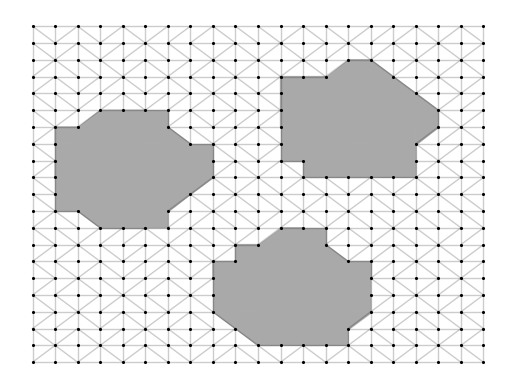

In [38]:
n_side, point_gen_mode = 21, 0

r1, r2 = 0.6, 0.3
n_holes = 3
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
#hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

# Make reference

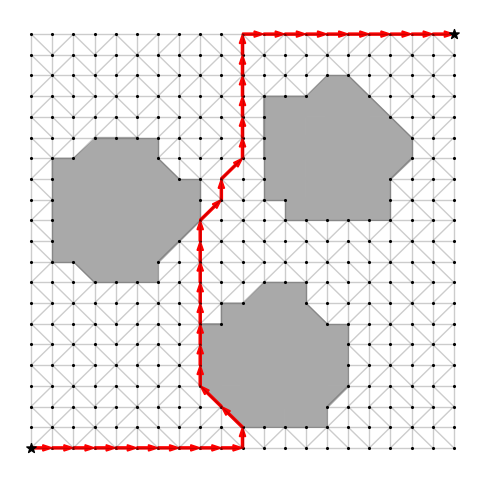

In [104]:
ref_path_coords = [(-1,-1), (0,-1), (0,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

start, end = ref_path.nodes[0], ref_path.nodes[-1]

# Make sleeve from graph

In [105]:
G = make_sleeve_graph(SC, start, end, ref_path)

pos = {}
for node in G.nodes:
    pos[node] = SC.nodes[node]

short_path = Trajectory(SC, nx.dijkstra_path(G, start, end))
short_path

0-22-43-65-66-88-109-131-153-174-196-217-239-261-282-304-325-346-368-369-370-392-393-415-416-417-439-440

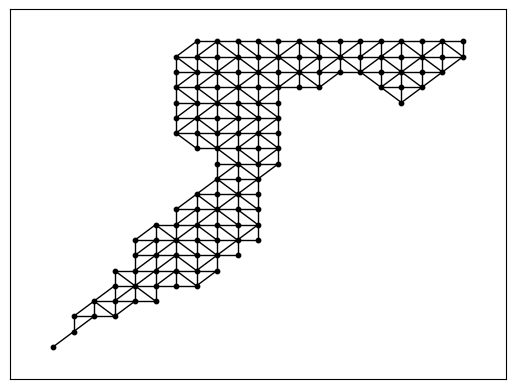

In [106]:
nx.draw_networkx(G, pos, with_labels=False, node_size=10, node_color='black')

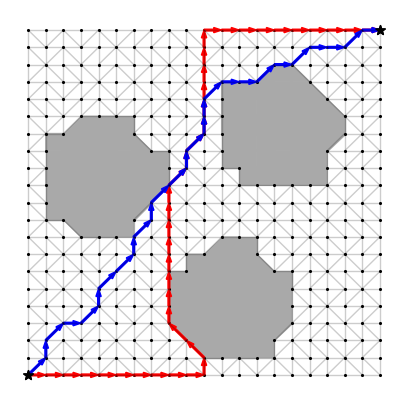

In [107]:
dijkstra_tree(SC, short_path, [None], ref_path_class, plot_others=False, plot_proj=False)

# Tough example

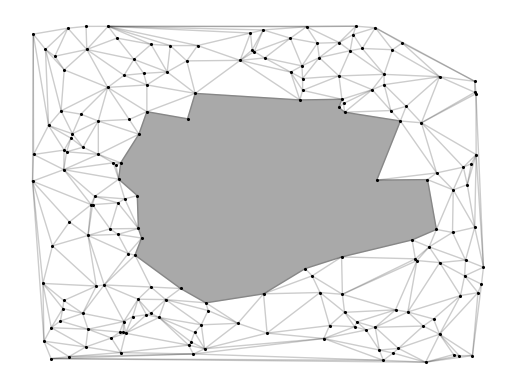

In [44]:
n_side, point_gen_mode = 15, 1

r1, r2 = 0, 0.5
n_holes = 1
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

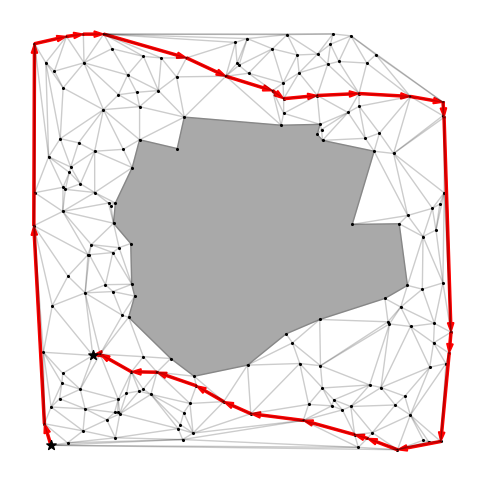

In [45]:
ref_path_coords = [(-1,-1), (-1,1), (1,1), (1,-1), (-0.8,-0.5)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

start, end = ref_path.nodes[0], ref_path.nodes[-1]

reverse_ref = Trajectory(SC, ref_path.nodes[::-1])

In [46]:
G = make_sleeve_graph(SC, start, end, ref_path)

pos = {}
for node in G.nodes:
    pos[node] = SC.nodes[node]

short_path = Trajectory(SC, nx.dijkstra_path(G, start, end))
short_path

[0.17636223] [1.843071]
[0.17636223] [1.843071]
[0.17636223] [1.843071]
[0.17636223] [1.843071]
[0.17636223] [1.843071]
[0.17636223] [1.843071]
[1.843071] [1.843071]
[1.843071] [1.843071]
[1.843071] [1.843071]
[1.843071] [1.843071]


NetworkXNoPath: No path to 35.

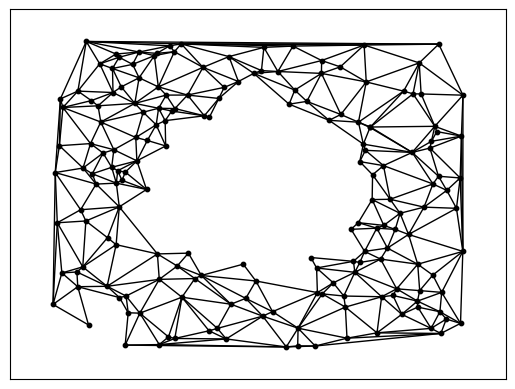

In [ ]:
nx.draw_networkx(G, pos, with_labels=False, node_size=10, node_color='black')

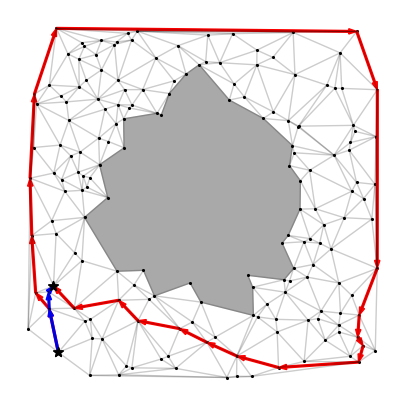

In [ ]:
dijkstra_tree(SC, short_path, [None], ref_path_class, plot_others=False, plot_proj=False)

NetworkXError: Node 143 has no position.

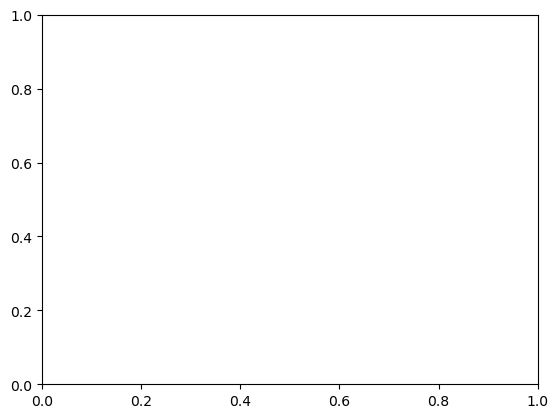

In [26]:
reverse_ref = Trajectory(SC, ref_path.nodes[::-1])
G_reverse = make_sleeve_graph(SC, end, start, reverse_ref)
nx.draw_networkx(G_reverse, pos, with_labels=False, node_size=10, node_color='black')

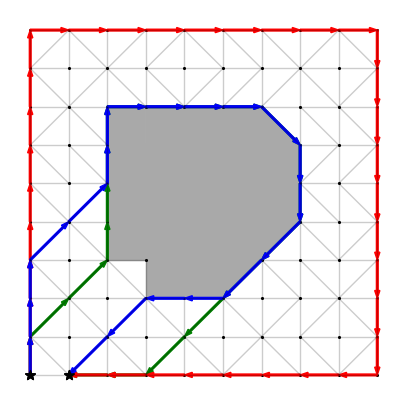

In [ ]:
short_path_reverse = Trajectory(SC, nx.dijkstra_path(G, end, start))


dijkstra_tree(SC, short_path, [Trajectory(SC, short_path_reverse.nodes[::-1])], ref_path_class, plot_others=True, plot_proj=False)